# Analyze Results
Processes the JSON file returned from the model and also runs evaluation code for different image captionign metrics

In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

## Process JSON File

In [2]:
FILE = 'blockMaleConf'
FOLDER = 'gender neutral'

In [3]:
filepath = '../results/{0}/{1}.json'.format(FOLDER, FILE)

In [4]:
input_file = open(filepath)
json_array = json.load(input_file)

In [5]:
os.path.basename(json_array[0]['filename'])

'f_f_sports_515982_2.jpg'

In [6]:
parsed_results = []
for img in json_array:
    caption = img['caption']
    file = os.path.basename(img['filename']).split('_')
    file_num = file[3].split('.')[0]
    gender = file[1]
    category = file[2]
    source = os.path.basename(img['filename'])
    if source is 'f':
        source = 'Flickr'
    else:
        source = 'COCO'
    parsed_results.append([caption, file_num, gender, category, source, os.path.basename(img['filename'])])
    print('Caption: {0} Gender: {1} Category: {2} Source: {3}'.format(caption, gender, category, source))

Caption: a baseball player sliding into home base. Gender: f Category: sports Source: COCO
Caption: a black and white photo of a man in a suit and tie. Gender: f Category: tie Source: COCO
Caption: a group of young men playing a game of frisbee. Gender: f Category: frisbee Source: COCO
Caption: a person on a skateboard in a park. Gender: m Category: skateboard Source: COCO
Caption: a person jumping a skate board in the air. Gender: m Category: skateboard Source: COCO
Caption: a woman is eating a doughnut with sprinkles. Gender: f Category: toothbrush Source: COCO
Caption: a young boy holding a hot dog in his hands. Gender: m Category: hairdrier Source: COCO
Caption: a woman holding a tennis racquet on a tennis court. Gender: f Category: racket Source: COCO
Caption: a woman is standing on a skateboard in the street. Gender: f Category: skateboard Source: COCO
Caption: a close up of a person brushing his teeth. Gender: m Category: toothbrush Source: COCO
Caption: a woman brushing her tee

In [7]:
# saves captions to csv
import csv
with open('../results/{0}/{1}.csv'.format(FOLDER, FILE), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Caption', 'Filename', 'Gender', 'Category', 'Source', 'File'])
    for i in parsed_results:
        writer.writerow(i)

## Process Captions

In [9]:
# process result annotations
filepath = '../results/{0}/{1}.json'.format(FOLDER, FILE)
input_file = open(filepath)
json_array = json.load(input_file)

## Women Also Snowboard Metrics

In [13]:
def snowboard_metrics(GT_Gender, df, filename):
    gender_ratio = len(df[df['Gender_Predict'] == 'f']) / len(df[df['Gender_Predict'] == 'm'])
    error_rate = len(df[df['Gender_Correct'] == 0]) / (len(df['Gender_Correct']))
    print('Model Name: {2} | Ratio Delta: {0} | Error Rate: {1}'.format(round(GT_Gender - gender_ratio, 3), round(error_rate,3), filename))
    print('Male: {0} Female: {1}'.format(len(df[df['Gender_Predict'] == 'm']), len(df[df['Gender_Predict'] == 'f'])))

In [17]:
results = []
filepath = "../results/{0}".format(FOLDER)
for file in os.listdir(filepath):
    if file.endswith(".csv"):
        results.append(os.path.join(filepath, file))

In [18]:
for result in results:
    df = pd.read_csv(result)
    correct = []
    gt_gender = list(df['Gender'])
    pred_gender = list(df['Gender_Predict'])
    for index, i in enumerate(pred_gender):
        if i is 'n':
            correct.append(2)
        elif i is gt_gender[index]:
            correct.append(1)
        else:
            correct.append(0)
    df['Gender_Correct'] = correct
    df.to_csv(result, index=False)
    GT_Gender = len(df[df['Gender'] == 'f']) / len(df[df['Gender'] == 'm'])
    snowboard_metrics(GT_Gender, df, result)

Model Name: ../results/gender neutral/blockMale.csv | Ratio Delta: 0.481 | Error Rate: 0.223
Male: 48 Female: 21
Model Name: ../results/gender neutral/blockMaleConf.csv | Ratio Delta: 0.007 | Error Rate: 0.202
Male: 34 Female: 31
Model Name: ../results/gender neutral/blockNeutral.csv | Ratio Delta: 0.429 | Error Rate: 0.245
Male: 45 Female: 22
Model Name: ../results/gender neutral/blockNeutralConf.csv | Ratio Delta: -0.151 | Error Rate: 0.213
Male: 29 Female: 31
Model Name: ../results/gender neutral/blockNeutralConf_2.csv | Ratio Delta: 0.033 | Error Rate: 0.211
Male: 35 Female: 31


## Format Captions

In [159]:
FILE = 'blockMale'

In [21]:
def formatResults(filename, save):
    df = pd.read_csv(filename)
    files = df['File'].tolist()
    captions = df['Caption'].tolist()
    result = []
    for index, file in enumerate(files):
        split = file.split('_')
        if split[0] is 'm':
            result.append({'image_id': split[3].split('.')[0], "caption": captions[index]})
        else:
            matches = json_array[file]
            for match in matches:
                match_split = match.split('_')
                result.append(({'image_id': match_split[3].split('.')[0] + "6", "caption": captions[index]}))
    with open('../results/res{0}.json'.format(save), 'w') as f:
        json.dump(result, f)

In [22]:
filepath = '../annotations/similarMatch.json'
input_file = open(filepath)
json_array = json.load(input_file)

In [23]:
df = pd.read_csv('../results/{0}/{1}.csv'.format(FOLDER, FILE))
files = df['File'].tolist()
captions = df['Caption'].tolist()

In [25]:
results = []
for file in os.listdir("../results/{0}".format(FOLDER)):
    if file.endswith(".csv"):
        print(file)
        save = file.split('.')[0]
        formatResults(os.path.join("../results/{0}/".format(FOLDER), file), save)

blockMale.csv
blockMaleConf.csv
blockNeutral.csv
blockNeutralConf.csv
blockNeutralConf_2.csv


In [34]:
df = pd.read_csv("../annotations/gtValidation.csv")
df.head()
image_id_f = [int(str(m) + '6') for m in df['image_id_m'].tolist()]
df['image_id_f'] = image_id_f
df.to_csv("../annotations/gtValidation.csv", index=False)

In [26]:
gt = {}
male_ids = df['image_id_m'].tolist()
coco_caption = df['coco_caption'].tolist()
for index, m in enumerate(male_ids):
    if m not in gt:
        gt[m] = [{'image_id': m, 'caption': coco_caption[index]}]
    else:
        gt[m].append({'image_id': m, 'caption': coco_caption[index]})

In [27]:
female_ids = df['image_id_f'].tolist()
f_caption = df['sim_caption'].tolist()
for index, m in enumerate(female_ids):
    if m not in gt:
        gt[m] = [{'image_id': m, 'caption': f_caption[index]}]
    else:
        gt[m].append({'image_id': m, 'caption': f_caption[index]})

In [28]:
with open('../results/gtAnns.json', 'w') as f:
    json.dump(gt, f)

## Generate Loss Function Graphs

In [3]:
losses = []
filepath = "../results/loss"
for file in os.listdir(filepath):
    if file.endswith(".txt"):
        losses.append(os.path.join(filepath, file))

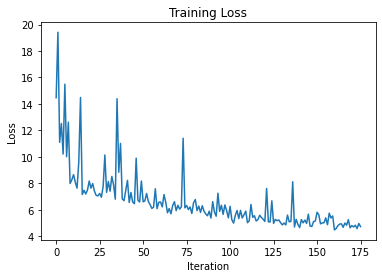

In [36]:
for loss in losses[2:3]:
    with open(loss) as f:
        content = f.readlines()
        # you may also want to remove whitespace characters like `\n` at the end of each line
        content = [float(x.strip().split('=')[-1].split('(')[0]) for x in content] 
        plt.plot(content)
        plt.title('Training Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.savefig('../results/loss/blockNeutral')